In [205]:
import time
import pylab as py
py.rcParams.update({'font.size': 14})
import pandas as pd # Importação da biblioteca pandas para leitura dos dados
import numpy as np # Importação da biblioteca np para manipulação de dados
import matplotlib.pyplot as plt

dados_ano=pd.read_csv("dados1semana_mod.txt") # Leitura dos dados de geração e carga de 1 ano

def geracao_solar(dados_ano):
    # Defiições do painel fotovoltaico utilizado
    # Painel Himalaya G12 Huasun 715 W	210mm	N-Type HC Bifacial MBB	23.0 %
    n_PV = 0.23
    n_conv = 0.9
    area_painel = 3.12
    numero_paineis = 10000 #equivale a 7.15 MW instalados
    # Geração fotovoltaica
    Pot_PV = dados_ano.radiacao * n_PV * n_conv * area_painel * numero_paineis
    Pot_PV = np.array(Pot_PV)
    Pot_PV = Pot_PV/1000000 #MW
    return Pot_PV

def geracao_eolica(dados_ano):
    # Definições para ajuste  de velocidade do vento # Turbina Eólica Generica do Homer Pro 1.5MW
    # Dados de vento medidos a 2m de altura
    H0 = 2
    H = 150    # Altura da nacele aerogerador
    Fator_rugosidade = 0.23
    vento_corrigido = dados_ano.vento * (H / H0) ** Fator_rugosidade

    # Definições do aerogerador utilizado
    Pot_max_GE = 1500000 #W
    Vc = 4.0
    Vf = 25
    Vr = 14
    numero_aerogeradores = 40 #equivale a 60 MW instalados
    
    # Geração eólica
    Pot_GE = np.zeros(len(vento_corrigido))
    index = set(dados_ano.index[vento_corrigido >= Vc].tolist()) & set(dados_ano.index[vento_corrigido <= Vr].tolist())
    Pot_GE[list(index)] = Pot_max_GE * ((vento_corrigido[list(index)] - Vc) / (Vr - Vc)) * numero_aerogeradores
    index = set(dados_ano.index[vento_corrigido >= Vr].tolist()) & set(dados_ano.index[vento_corrigido <= Vf].tolist())
    Pot_GE[list(index)] = Pot_max_GE * numero_aerogeradores

    Pot_GE = Pot_GE/1000000 #MW
    return Pot_GE

def cal_net_load(dados_ano, carga_fixa):
    # Carga da rede
    carga = np.array(dados_ano.demanda)
    net_load = np.zeros(len(dados_ano.hora))
    net_load = geracao_eolica(dados_ano) + geracao_solar(dados_ano) - carga_fixa  # 3MW de carga
    return net_load


In [206]:
Pot_Eolica = geracao_eolica(dados_ano)
print(np.mean(Pot_Eolica))

35.82372419945585


In [207]:
def BESS(net_load, BESS_capacity, soc_min, soc_max, soc_int, carga_fixa): # Soe = State of Energy
    if BESS_capacity < 0:
        loee_t=10*abs(BESS_capacity)+1
    else:
        soe = np.zeros(len(net_load))
        soe_min = soc_min * BESS_capacity #trocar o nome de BESS_energy para BESS_capacity
        soe_max = soc_max * BESS_capacity
        soe_int = soc_int * BESS_capacity
        soe[0] = soe_int
        perdas = 0
        loee = 0
        ii=0
        for i in range(len(net_load)-1): 
            soe[i+1] = soe[i] + (net_load[i])
            if soe[i+1] > soe_max:
                soe[i+1] = soe_max
            elif soe[i+1] < soe_min:
                soe[i+1] = soe_min
                perdas = - ((net_load[i]) - (soe_min - soe [i]))
                loee = loee + perdas
        loee_t=loee/(carga_fixa*len(net_load))
    return loee_t

In [208]:
#Avalia o custo da posicao avaliada
def fitness(net_load, BESS_energy, soc_min, soc_max, soc_int, dados_ano, lpsp_max, Np, carga_fixa):
    lpsp = np.zeros(Np)
    custo_bess = np.zeros(Np)
    for i in range(Np):
        lpsp[i] = BESS(net_load, BESS_energy[i], soc_min, soc_max, soc_int, carga_fixa)
        if lpsp[i] > lpsp_max:
            custo_bess[i] = BESS_energy[i]+10+lpsp[i]*1000
        else:
            custo_bess[i] = BESS_energy[i]
    custo_bess = custo_bess
    return  custo_bess

In [209]:
# Variáveis do Problema
soc_min = 0.1
soc_max = 0.9
soc_int = 0.9
lpsp_max = 0.05
carga_fixa = 15 # Carga fixa
net_load = cal_net_load(dados_ano, carga_fixa)


# Control parameters
w = 0.5                   # Intertial weight. In some variations, it is set to vary with iteration number.
c1 = 2.0                  # Weight of searching based on the optima found by a particle
c2 = 2.0                  # Weight of searching based on the optima found by the swarm
v_fct = 1                 # Velocity adjust factor. Set to 1 for standard PSO.


Np = 100                 # population size (number of particles)
D = 1                     # dimension (= no. of parameters in the fitness function)
max_iter = 20         # maximum number of iterations 
xL = np.zeros(D) + 0.1      # lower bound (does not need to be homogeneous)  
xU = np.zeros(D) + 20      # upper bound (does not need to be homogeneous)   



# Fitness function. The code maximizes the value of the fitness function

# Defining and intializing variables
    
pbest_val = np.zeros(Np)            # Personal best fintess value. One pbest value per particle.
gbest_val = np.zeros(max_iter)      # Global best fintess value. One gbest value per iteration (stored).

pbest = np.zeros((D,Np))            # pbest solution
gbest = np.zeros(D)                 # gbest solution

gbest_store = np.zeros((D,max_iter))   # storing gbest solution at each iteration

pbest_val_avg_store = np.zeros(max_iter)
fitness_avg_store = np.zeros(max_iter)

x = np.random.rand(D,Np)            # Initial position of the particles
v = np.zeros((D,Np))                # Initial velocity of the particles




# Setting the initial position of the particles over the given bounds [xL,xU]
for m in range(D):    
    x[m,:] = xL[m] + (xU[m]-xL[m])*x[m,:]
a=x
t_start = time.time()

# Loop over the generations
for iter in range(0,max_iter):
    
    if iter > 0:                             # Do not update postion for 0th iteration
        r1 = np.random.rand(D,Np)            # random numbers [0,1], matrix D x Np
        r2 = np.random.rand(D,Np)            # random numbers [0,1], matrix D x Np   
        v_global = np.multiply(((x.transpose()-gbest).transpose()),r2)*c2*(-1.0)    # velocity towards global optima
        v_local = np.multiply((pbest- x),r1)*c1           # velocity towards local optima (pbest)
    
        v = w*v + (v_local + v_global)       # velocity update
        x = x + v*v_fct                      # position update
    
    fit = fitness(net_load, x[0], soc_min, soc_max, soc_int, dados_ano, lpsp_max, Np, carga_fixa)                        # fitness function call (once per iteration). Vector Np
    
    if iter == 0:
        pbest_val = np.copy(fit)             # initial personal best = initial fitness values. Vector of size Np
        pbest = np.copy(x)                   # initial pbest solution = initial position. Matrix of size D x Np
    else:
        # pbest and pbest_val update
        ind = np.argwhere(fit < pbest_val)   # indices where current fitness value set is greater than pbset
        pbest_val[ind] = np.copy(fit[ind])   # update pbset_val at those particle indices where fit > pbest_val
        pbest[:,ind] = np.copy(x[:,ind])     # update pbest for those particle indices where fit > pbest_val

    # gbest and gbest_val update
    ind2 = np.argmin(pbest_val)                       # index where the fitness is maximum
    gbest_val[iter] = np.copy(pbest_val[ind2])        # store gbest value at each iteration
    gbest = np.copy(pbest[:,ind2])                    # global best solution, gbest
    
    gbest_store[:,iter] = np.copy(gbest)              # store gbest solution
    
    pbest_val_avg_store[iter] = np.mean(pbest_val)
    fitness_avg_store[iter] = np.mean(fit)
    print("Iter. =", iter, ". gbest_val = ", gbest_val[iter], ". gbest = ", gbest)  # print iteration no. and best solution at each iteration
    

t_elapsed = time.time() - t_start
print("\nElapsed time = %.4f s" % t_elapsed)





Iter. = 0 . gbest_val =  5.122877205871834 . gbest =  [5.12287721]
Iter. = 1 . gbest_val =  5.053931370922607 . gbest =  [5.05393137]
Iter. = 2 . gbest_val =  5.041472445328528 . gbest =  [5.04147245]
Iter. = 3 . gbest_val =  5.041472445328528 . gbest =  [5.04147245]
Iter. = 4 . gbest_val =  5.041472445328528 . gbest =  [5.04147245]
Iter. = 5 . gbest_val =  5.041472445328528 . gbest =  [5.04147245]
Iter. = 6 . gbest_val =  5.041472445328528 . gbest =  [5.04147245]
Iter. = 7 . gbest_val =  5.041209081597576 . gbest =  [5.04120908]
Iter. = 8 . gbest_val =  5.041209081597576 . gbest =  [5.04120908]
Iter. = 9 . gbest_val =  5.041209081597576 . gbest =  [5.04120908]
Iter. = 10 . gbest_val =  5.041209081597576 . gbest =  [5.04120908]
Iter. = 11 . gbest_val =  5.039713923307195 . gbest =  [5.03971392]
Iter. = 12 . gbest_val =  5.039713923307195 . gbest =  [5.03971392]
Iter. = 13 . gbest_val =  5.039713923307195 . gbest =  [5.03971392]
Iter. = 14 . gbest_val =  5.039713923307195 . gbest =  [5.

Text(0, 0.5, 'Best solution, gbest[:,iter]')

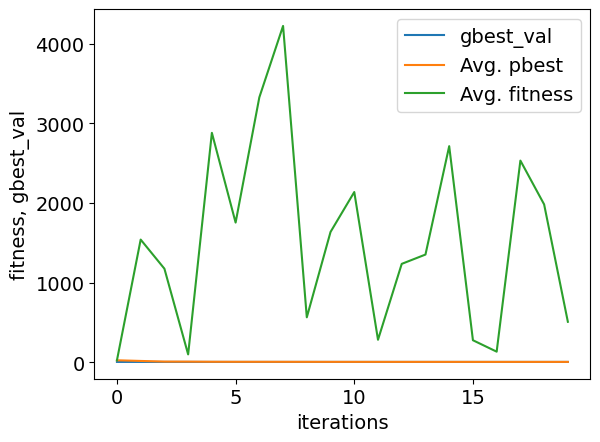

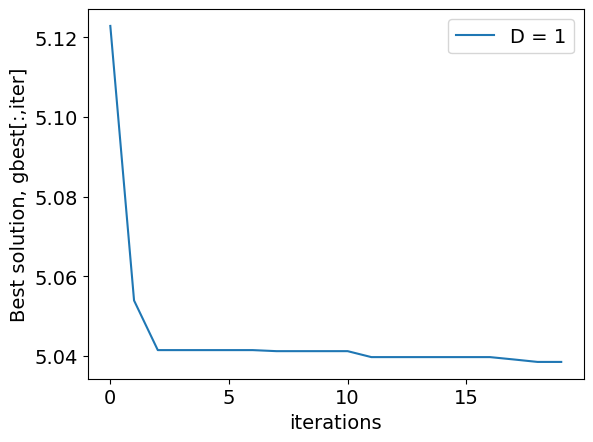

In [210]:
# Plotting
py.close('all')
py.plot(gbest_val,label = 'gbest_val')
py.plot(pbest_val_avg_store, label = 'Avg. pbest')
py.plot(fitness_avg_store, label = 'Avg. fitness')
py.legend()
py.gca().set(xlabel='iterations', ylabel='fitness, gbest_val')

py.xlabel('iterations')
py.ylabel('fitness, gbest_val')


py.figure()
for m in range(D):
    py.plot(gbest_store[m,:],label = 'D = ' + str(m+1))
    
py.legend()
py.xlabel('iterations')
py.ylabel('Best solution, gbest[:,iter]')

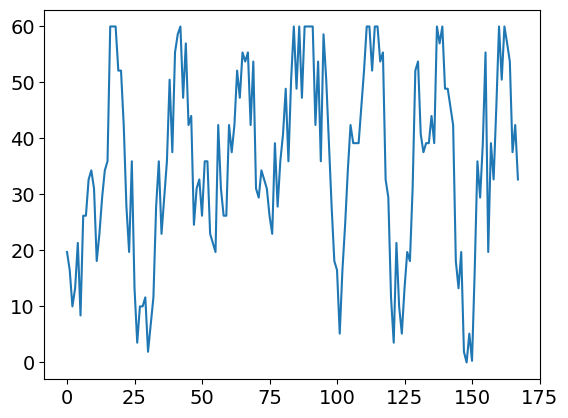

In [211]:
# x axis values
x = list(np.arange(0,len(dados_ano)))
# corresponding y axis values
y = geracao_solar(dados_ano)

z = geracao_eolica(dados_ano)

p = cal_net_load(dados_ano, carga_fixa)

l = dados_ano.demanda

# # plotting the points
# # plt.plot(x, y)
plt.plot(x, z)
# # plt.plot(x, p)
# plt.plot(x, l)
# function to show the plot
plt.show()
# plt.savefig('filename.png', dpi=500)
